# Filter Features Selection - RFE (with Scikit Learn)

Feature selection is the process of reducing the number of input variables when developing a predictive model.

There are many different types of feature selection algorithms, although they can broadly be grouped into two main types:

- **Wrapper Feature Selection**: Search for well-performing subsets of features.
- **Filter Feature Selection**: Select subsets of features based on their relationship with the target.

In present notebook will be shown the second one group of methods.

RFE works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains.

This is achieved by fitting the given machine learning algorithm used in the core of the model, ranking features by importance, discarding the least important features, and re-fitting the model. This process is repeated until a specified number of features remains.

Note RFE requires the previous selection of number of features. However, there are ways to optimize this number of features to finally be used.

#### References:
- [Feature Selection with Stochastic Optimization Algorithms](https://machinelearningmastery.com/feature-selection-with-optimization/)
- [How to Choose a Feature Selection Method For Machine Learning](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)
- [Recursive Feature Elimination (RFE) for Feature Selection in Python](https://machinelearningmastery.com/rfe-feature-selection-in-python/)

## RFE: exploring the Number of Features

>2 0.716 (0.043)
>3 0.818 (0.036)
>4 0.874 (0.027)
>5 0.883 (0.033)
>6 0.889 (0.031)
>7 0.887 (0.031)
>8 0.888 (0.029)
>9 0.882 (0.026)


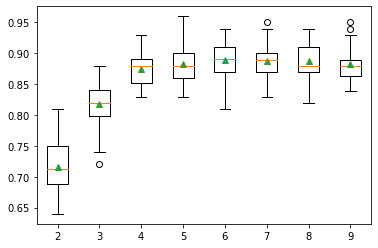

In [14]:
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(2, 10):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='f1_macro', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

### Which features were selected

In this case could be selected 5 (mininum number of features with a good performance).

In [15]:
# report which features were selected by RFE
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
# fit RFE
rfe.fit(X, y)
# summarize all features
for i in range(X.shape[1]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 4.000
Column: 1, Selected False, Rank: 5.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected False, Rank: 6.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected False, Rank: 3.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected False, Rank: 2.000


## RFE: automatic Number of Features selection

In this case, we can see the RFE that uses a decision tree and automatically selects a number of features and then fits a decision tree on the selected features achieves a classification accuracy of about 88.6 percent.

In [3]:
# automatically select the number of features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# create pipeline
rfe = RFECV(estimator=DecisionTreeClassifier())
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='f1_macro', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.885 (0.026)


## RFE: Explore Base Algorithm to be used as selector

There are many algorithms that can be used in the core RFE, as long as they provide some indication of variable importance.

Most decision tree algorithms are likely to report the same general trends in feature importance, but this is not guaranteed. It might be helpful to explore the use of different algorithms wrapped by RFE.

>lr 0.892 (0.031)
>per 0.842 (0.040)
>cart 0.884 (0.031)
>rf 0.863 (0.041)
>gbm 0.887 (0.032)


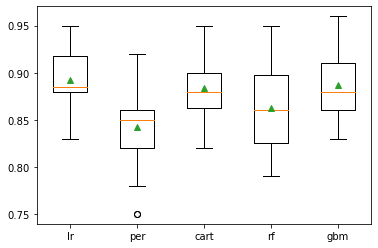

In [16]:
# explore the algorithm wrapped by RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	# lr
	rfe = RFE(estimator=LogisticRegression(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
	# perceptron
	rfe = RFE(estimator=Perceptron(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['per'] = Pipeline(steps=[('s',rfe),('m',model)])
	# cart
	rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
	# rf
	rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
	# gbm
	rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=5)
	model = DecisionTreeClassifier()
	models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()